<a href="https://colab.research.google.com/github/YamenObeidat/Machine-Learning-Final-Project-1/blob/main/edit3%3A30AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**-----*Data* *Understanding* & *Preprocessing*-----**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve)


In [3]:


drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/orders.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__prior.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__train.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/products.csv.zip" -d /content/

path1 = '/content/drive/MyDrive/' # for the csv files
path2 = '/content/' # for the zip files
def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

aisles = reduce_mem(pd.read_csv(path1 + 'aisles.csv'))
departments = reduce_mem(pd.read_csv(path1 + 'departments.csv'))
products = reduce_mem(pd.read_csv(path2 + 'products.csv'))

orders = reduce_mem(pd.read_csv(path2 + 'orders.csv'  ))
order_products_prior = reduce_mem(pd.read_csv(path2 + 'order_products__prior.csv',))

order_products_train = reduce_mem(pd.read_csv(path2 + 'order_products__train.csv'))

datasets = {
    "Aisles": aisles,
    "Departments": departments,
    "Products": products,
    "Orders": orders,
    "Prior": order_products_prior,
    "Train": order_products_train
}

for name, df in datasets.items():
    print(f"{name} Columns: {df.columns.tolist()}")

columns = []
for df in datasets.values():
    columns += list(df.columns)

print(f"Number of columns: {len(columns)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/orders.csv.zip
replace /content/orders.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/order_products__prior.csv.zip
replace /content/order_products__prior.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/order_products__train.csv.zip
replace /content/order_products__train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Archive:  /content/drive/MyDrive/products.csv.zip
replace /content/products.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
Aisles Columns: ['aisle_id', 'aisle']
Departments Columns: ['department_id', 'department']
Products Columns: ['product_id', 'product_name', 'aisle_id', 'department_id']
Orders Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Prior Columns: ['order_id', 'product_i

In [4]:
# I merged products, aisles, and departments into a single products_merged table, to link every product ID to its category name.
products_merged = pd.merge(products, aisles, on='aisle_id', how='inner')
products_merged = pd.merge(products_merged, departments, on='department_id', how='inner')
products_merged = products_merged.drop(['aisle_id', 'department_id'], axis=1)
products_merged.head(10)


,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry
5,6,Dry Nose Oil,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,water seltzer sparkling water,beverages


In [8]:
print(orders.isnull().sum())

''' sample contains 206K unique customers. the reason this column has more than 206K
missing values is because they are each time a unique customer made
the first purchase. (no previous purchases exist if its the first purchase).
If we ignore the first purchase then: '''

avg_days = orders[orders['order_number'] > 1]['days_since_prior_order'].mean()
print(f"Average days between orders: {avg_days : .2f} days")


order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64
Average days between orders:  11.11 days


In [9]:
# First we replace missing values with 0 :
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
print(f"Remaining missing values: {orders["days_since_prior_order"].isnull().sum()}")


Remaining missing values: 0


In [11]:
order_products_prior = pd.merge(order_products_prior, orders[['order_id', 'user_id', 'days_since_prior_order']], on='order_id', how='left')

user_features = order_products_prior.groupby('user_id').agg({
    'order_id': 'nunique',
    'days_since_prior_order': 'mean',
    'reordered': 'mean'
}).reset_index()

user_features.columns = ['user_id', 'user_total_orders', 'user_avg_days_reorder', 'user_reorder_ratio']
user_features.head()

,user_id,user_total_orders,user_avg_days_reorder,user_reorder_ratio
0,1,10,18.542374,0.694915
1,2,14,14.902564,0.476923
2,3,12,10.181818,0.625000
3,4,5,11.944445,0.055556
4,5,4,10.189189,0.378378


In [12]:
user_basket = order_products_prior.groupby(['user_id', 'order_id']).size().groupby('user_id').mean().reset_index()
user_basket.columns = ['user_id', 'user_avg_basket_size']

user_df = pd.merge(user_features, user_basket, on='user_id', how='left')
user_df.head()

,user_id,user_total_orders,user_avg_days_reorder,user_reorder_ratio,user_avg_basket_size
0,1,10,18.542374,0.694915,5.900000
1,2,14,14.902564,0.476923,13.928571
2,3,12,10.181818,0.625000,7.333333
3,4,5,11.944445,0.055556,3.600000
4,5,4,10.189189,0.378378,9.250000


In [13]:
product_stats = order_products_prior.groupby('product_id').agg({
    'reordered': 'mean',
    'order_id': 'count',
    'add_to_cart_order': 'mean'
}).reset_index()

product_stats.columns = ['product_id', 'reorder_rate', 'total_sales', 'avg_cart_position']
product_df = pd.merge(products_merged, product_stats, on='product_id', how='left').fillna(0)
product_df.head()

,product_id,product_name,aisle,department,reorder_rate,total_sales,avg_cart_position
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks,0.613391,1852.0,5.801836
1,2,All-Seasons Salt,spices seasonings,pantry,0.133333,90.0,9.888889
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages,0.732852,277.0,6.415162
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen,0.446809,329.0,9.507599
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry,0.600000,15.0,6.466667


In [14]:
up_features = order_products_prior.groupby(['user_id', 'product_id']).agg({
    'order_id': 'nunique',
    'add_to_cart_order': 'mean'
}).reset_index()

up_features.columns = ['user_id', 'product_id', 'up_purchase_count', 'up_avg_cart_pos']
up_features = pd.merge(up_features, user_df[['user_id', 'user_total_orders']], on='user_id', how='left')
up_features['up_reorder_ratio'] = up_features['up_purchase_count'] / up_features['user_total_orders']
up_features.head()

,user_id,product_id,up_purchase_count,up_avg_cart_pos,user_total_orders,up_reorder_ratio
0,1,196,10,1.400000,10,1.0
1,1,10258,9,3.333333,10,0.9
2,1,10326,1,5.000000,10,0.1
3,1,12427,10,3.300000,10,1.0
4,1,13032,3,6.333333,10,0.3


In [15]:
temporal = orders[['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']].copy()

temporal['day_period'] = temporal['order_hour_of_day'].apply(
    lambda x: 1 if 5 <= x < 12 else (2 if 12 <= x < 17 else (3 if 17 <= x < 21 else 4))
)

temporal['is_weekend'] = temporal['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)

user_time = temporal.groupby('user_id').agg({
    'day_period': 'mean',
    'is_weekend': 'mean'
}).reset_index()

user_time.head()

,user_id,day_period,is_weekend
0,1,1.363636,0.272727
1,2,1.133333,0.400000
2,3,2.384615,0.615385
3,4,1.666667,0.000000
4,5,2.200000,0.600000


In [16]:
final_dataset = pd.merge(up_features, user_df, on='user_id', how='left')
final_dataset = pd.merge(final_dataset, product_df, on='product_id', how='left')
final_dataset = pd.merge(final_dataset, user_time, on='user_id', how='left')

train_orders = orders[orders['eval_set'] == 'train'][['order_id', 'user_id']]
train_labels = pd.merge(train_orders, order_products_train[['order_id', 'product_id', 'reordered']], on='order_id')
train_labels = train_labels[['user_id', 'product_id', 'reordered']]

final_dataset = pd.merge(final_dataset, train_labels, on=['user_id', 'product_id'], how='left')
final_dataset['reordered'] = final_dataset['reordered'].fillna(0)

final_dataset.head()

,user_id,product_id,up_purchase_count,up_avg_cart_pos,user_total_orders_x,up_reorder_ratio,user_total_orders_y,user_avg_days_reorder,user_reorder_ratio,user_avg_basket_size,product_name,aisle,department,reorder_rate,total_sales,avg_cart_position,day_period,is_weekend,reordered
0,1,196,10,1.400000,10,1.0,10,18.542374,0.694915,5.9,Soda,soft drinks,beverages,0.776480,35791.0,3.721774,1.363636,0.272727,1.0
1,1,10258,9,3.333333,10,0.9,10,18.542374,0.694915,5.9,Pistachios,nuts seeds dried fruit,snacks,0.713772,1946.0,4.277492,1.363636,0.272727,1.0
2,1,10326,1,5.000000,10,0.1,10,18.542374,0.694915,5.9,Organic Fuji Apples,fresh fruits,produce,0.652009,5526.0,4.191097,1.363636,0.272727,0.0
3,1,12427,10,3.300000,10,1.0,10,18.542374,0.694915,5.9,Original Beef Jerky,popcorn jerky,snacks,0.740735,6476.0,4.760037,1.363636,0.272727,0.0
4,1,13032,3,6.333333,10,0.3,10,18.542374,0.694915,5.9,Cinnamon Toast Crunch,cereal,breakfast,0.657158,3751.0,5.622767,1.363636,0.272727,1.0


/tmp/ipython-input-3989232499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders, x='order_dow', palette='viridis')


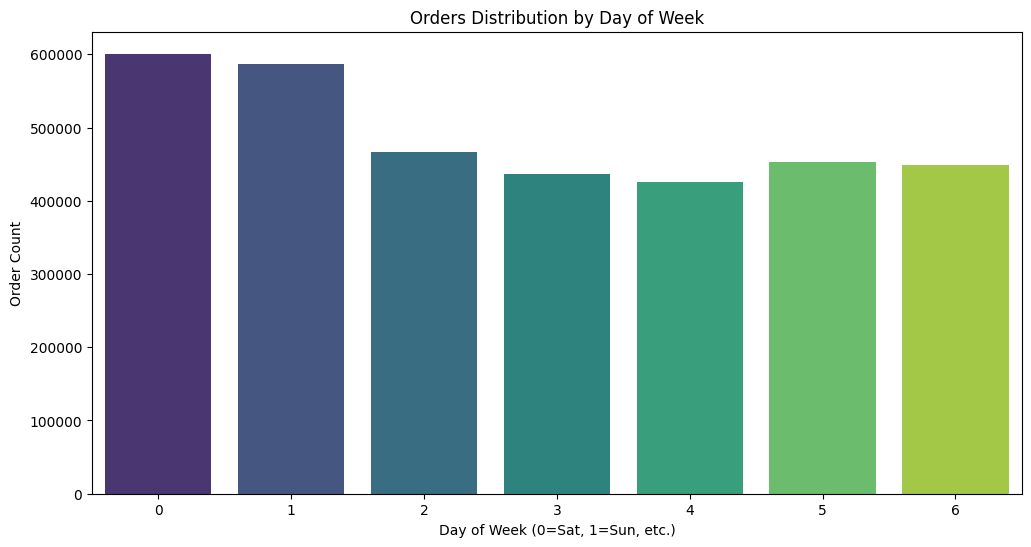

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=orders, x='order_dow', palette='viridis')
plt.title('Orders Distribution by Day of Week')
plt.xlabel('Day of Week (0=Sat, 1=Sun, etc.)')
plt.ylabel('Order Count')
plt.show()

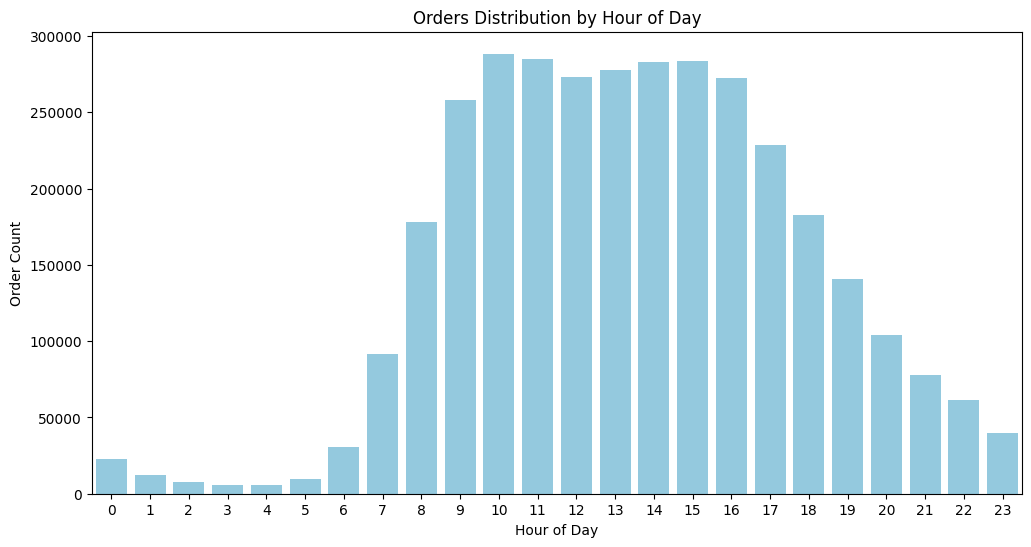

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(data=orders, x='order_hour_of_day', color='skyblue')
plt.title('Orders Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Order Count')
plt.show()

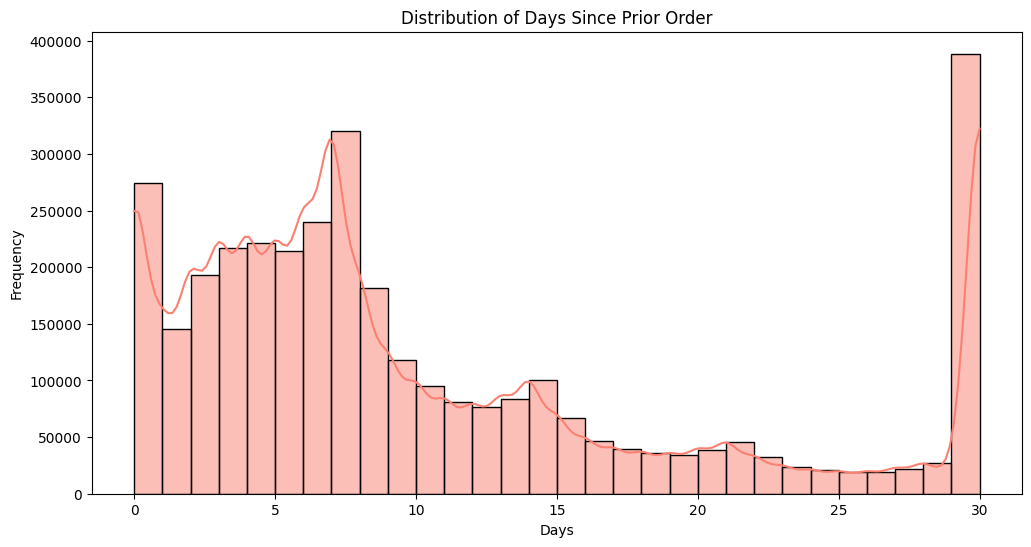

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(orders['days_since_prior_order'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()

/tmp/ipython-input-3487889895.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x='total_sales', y='product_name', palette='magma')


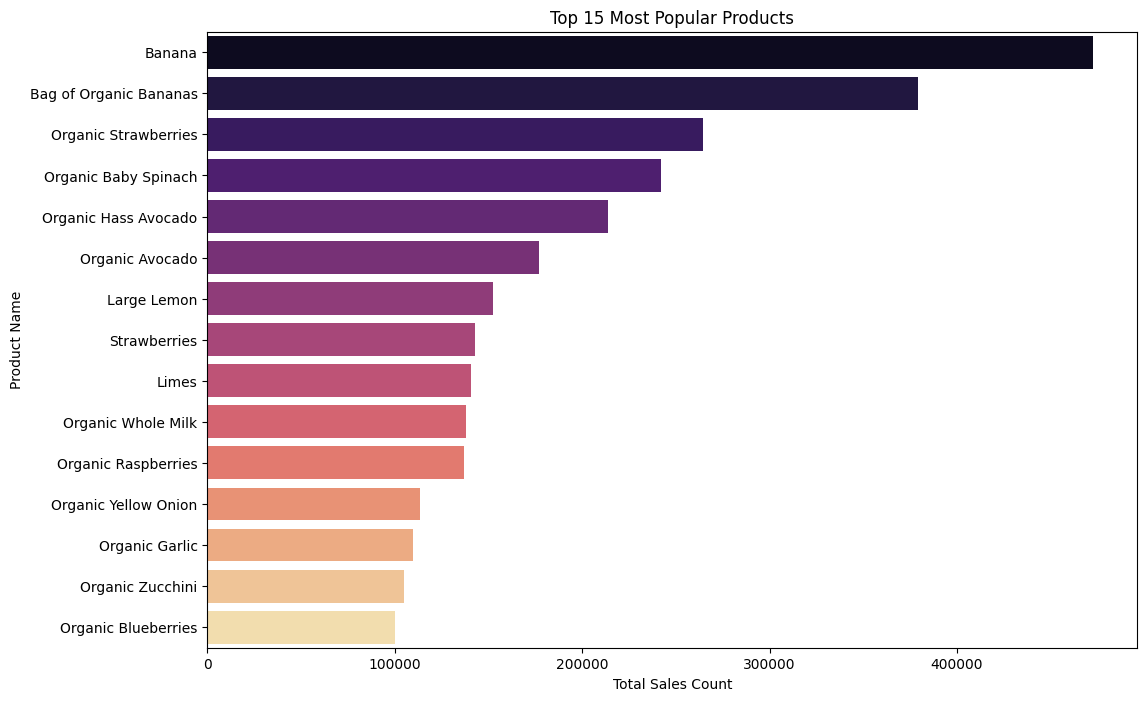

In [20]:
top_products = product_df.sort_values('total_sales', ascending=False).head(15)
plt.figure(figsize=(12, 8))
sns.barplot(data=top_products, x='total_sales', y='product_name', palette='magma')
plt.title('Top 15 Most Popular Products')
plt.xlabel('Total Sales Count')
plt.ylabel('Product Name')
plt.show()

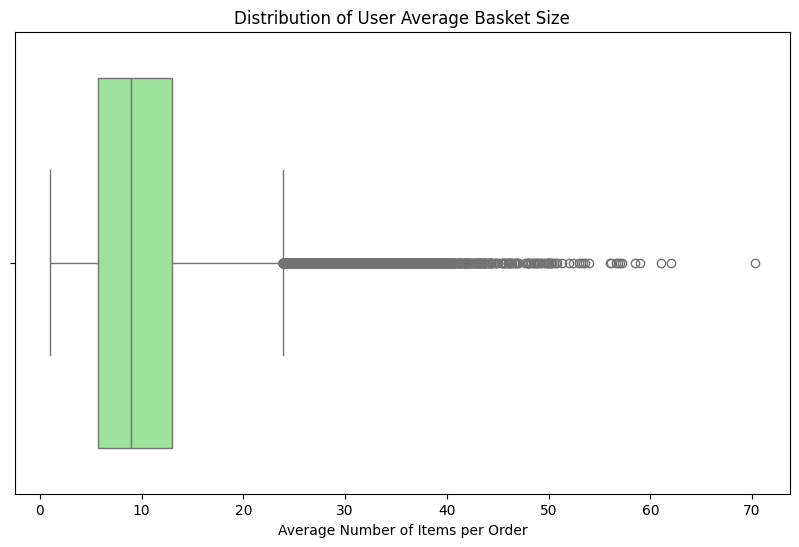

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=user_df, x='user_avg_basket_size', color='lightgreen')
plt.title('Distribution of User Average Basket Size')
plt.xlabel('Average Number of Items per Order')
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler

existing_cols = [c for c in cols_to_scale if c in final_dataset.columns]

scaler = StandardScaler()
final_dataset[existing_cols] = scaler.fit_transform(final_dataset[existing_cols])
final_dataset.head()

,user_id,product_id,up_purchase_count,up_avg_cart_pos,user_total_orders_x,up_reorder_ratio,user_total_orders_y,user_avg_days_reorder,user_reorder_ratio,user_avg_basket_size,product_name,aisle,department,reorder_rate,total_sales,avg_cart_position,day_period,is_weekend,reordered
0,1,196,2.127645,-1.119291,10,5.138871,10,1.318837,0.97841,-1.079576,Soda,soft drinks,beverages,1.489172,0.237898,-3.196833,1.363636,0.272727,1.0
1,1,10258,1.846314,-0.842478,10,4.531295,10,1.318837,0.97841,-1.079576,Pistachios,nuts seeds dried fruit,snacks,1.103190,-0.367857,-2.841709,1.363636,0.272727,1.0
2,1,10326,-0.404337,-0.603847,10,-0.329316,10,1.318837,0.97841,-1.079576,Organic Fuji Apples,fresh fruits,produce,0.723025,-0.303783,-2.896919,1.363636,0.272727,0.0
3,1,12427,2.127645,-0.847251,10,5.138871,10,1.318837,0.97841,-1.079576,Original Beef Jerky,popcorn jerky,snacks,1.269154,-0.286780,-2.533345,1.363636,0.272727,0.0
4,1,13032,0.158326,-0.412941,10,0.885837,10,1.318837,0.97841,-1.079576,Cinnamon Toast Crunch,cereal,breakfast,0.754721,-0.335551,-1.982029,1.363636,0.272727,1.0


In [25]:
X = final_dataset.drop(['user_id', 'product_id', 'reordered', 'product_name'], axis=1, errors='ignore')
y = final_dataset['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} rows")
print(f"Testing set: {X_test.shape[0]} rows")

Training set: 10646362 rows
Testing set: 2661591 rows


In [27]:
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist'
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97   2495826
         1.0       0.58      0.01      0.02    165765

    accuracy                           0.94   2661591
   macro avg       0.76      0.51      0.50   2661591
weighted avg       0.92      0.94      0.91   2661591



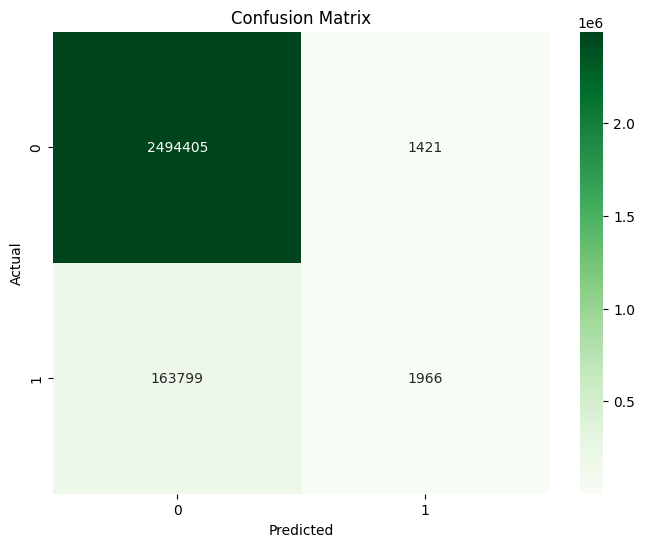

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

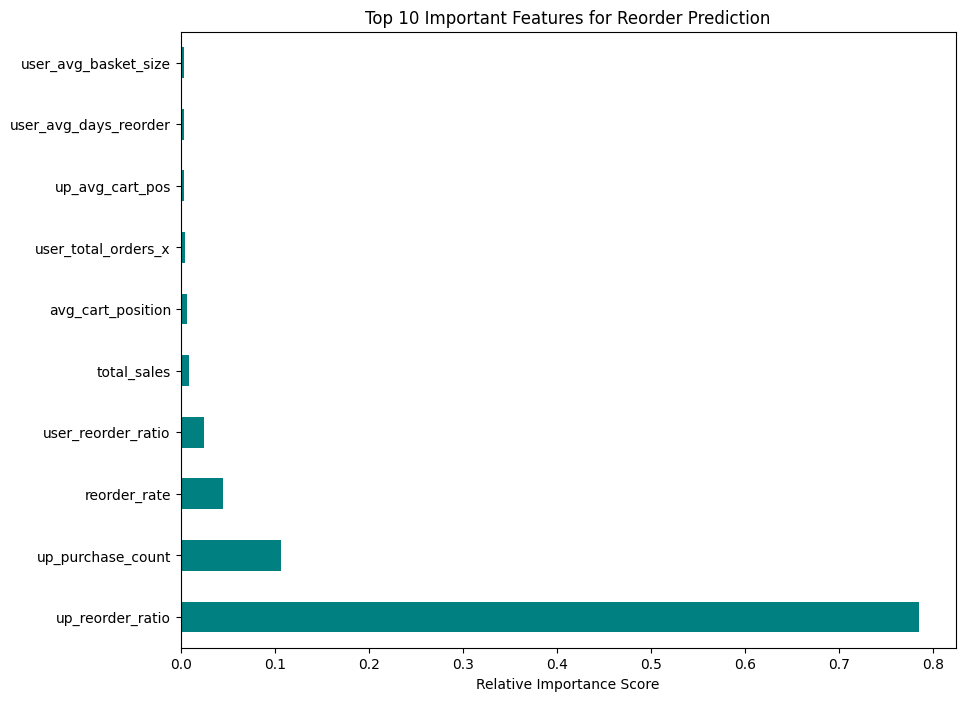

In [30]:
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Top 10 Important Features for Reorder Prediction')
plt.xlabel('Relative Importance Score')
plt.show()

In [31]:
from mlxtend.frequent_patterns import apriori, association_rules

# We use a subset of the data (100k rows) to avoid memory crashes in Colab
basket_data = order_products_prior.head(100000)
basket = (basket_data.groupby(['order_id', 'product_id'])['reordered']
          .count().unstack().reset_index().fillna(0)
          .set_index('order_id'))

def encode_units(x):
    if x <= 0: return 0
    if x >= 1: return 1

basket_sets = basket.applymap(encode_units)
basket_sets.head()

/tmp/ipython-input-3401929391.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-a

product_id,1,3,10,23,25,27,28,32,33,34,...,49665,49666,49667,49670,49678,49679,49680,49683,49685,49686
order_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [33]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules["antecedents_id"] = rules["antecedents"].apply(lambda x: list(x)[0])
rules["consequents_id"] = rules["consequents"].apply(lambda x: list(x)[0])

rules = rules.merge(products[['product_id', 'product_name']], left_on='antecedents_id', right_on='product_id', how='left')
rules = rules.rename(columns={'product_name': 'item_A'}).drop('product_id', axis=1)

rules = rules.merge(products[['product_id', 'product_name']], left_on='consequents_id', right_on='product_id', how='left')
rules = rules.rename(columns={'product_name': 'item_B'}).drop('product_id', axis=1)

rules[['item_A', 'item_B', 'support', 'confidence', 'lift']].sort_values('lift', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,item_A,item_B,support,confidence,lift
15,Organic Raspberries,Organic Strawberries,0.010034,0.233100,2.948067
14,Organic Strawberries,Organic Raspberries,0.010034,0.126904,2.948067
22,Honeycrisp Apple,Banana,0.010134,0.385496,2.592345
23,Banana,Honeycrisp Apple,0.010134,0.068151,2.592345
5,Organic Raspberries,Bag of Organic Bananas,0.013145,0.305361,2.523409
4,Bag of Organic Bananas,Organic Raspberries,0.013145,0.108624,2.523409
21,Organic Fuji Apple,Banana,0.010134,0.363309,2.443145
20,Banana,Organic Fuji Apple,0.010134,0.068151,2.443145
7,Organic Hass Avocado,Bag of Organic Bananas,0.018964,0.295313,2.440368
6,Bag of Organic Bananas,Organic Hass Avocado,0.018964,0.156716,2.440368


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

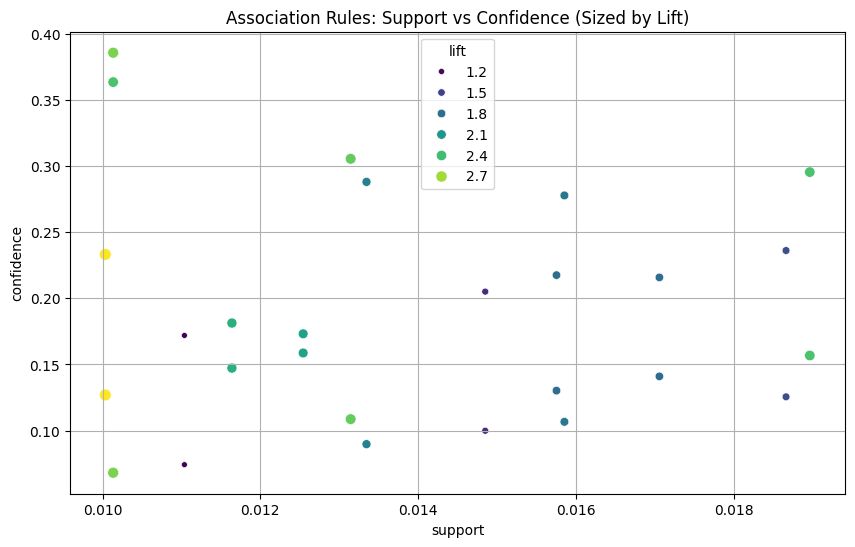

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="support", y="confidence", size="lift", data=rules, hue="lift", palette='viridis')
plt.title("Association Rules: Support vs Confidence (Sized by Lift)")
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

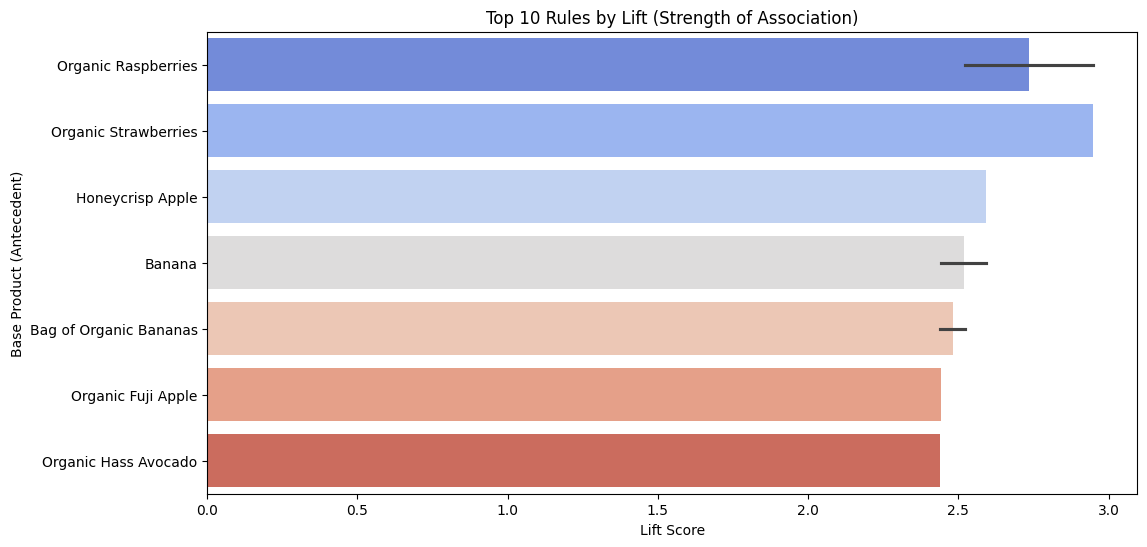

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [35]:
plt.figure(figsize=(12, 6))
top_rules = rules.sort_values('lift', ascending=False).head(10)
sns.barplot(x='lift', y='item_A', data=top_rules, palette='coolwarm')
plt.title('Top 10 Rules by Lift (Strength of Association)')
plt.xlabel('Lift Score')
plt.ylabel('Base Product (Antecedent)')
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

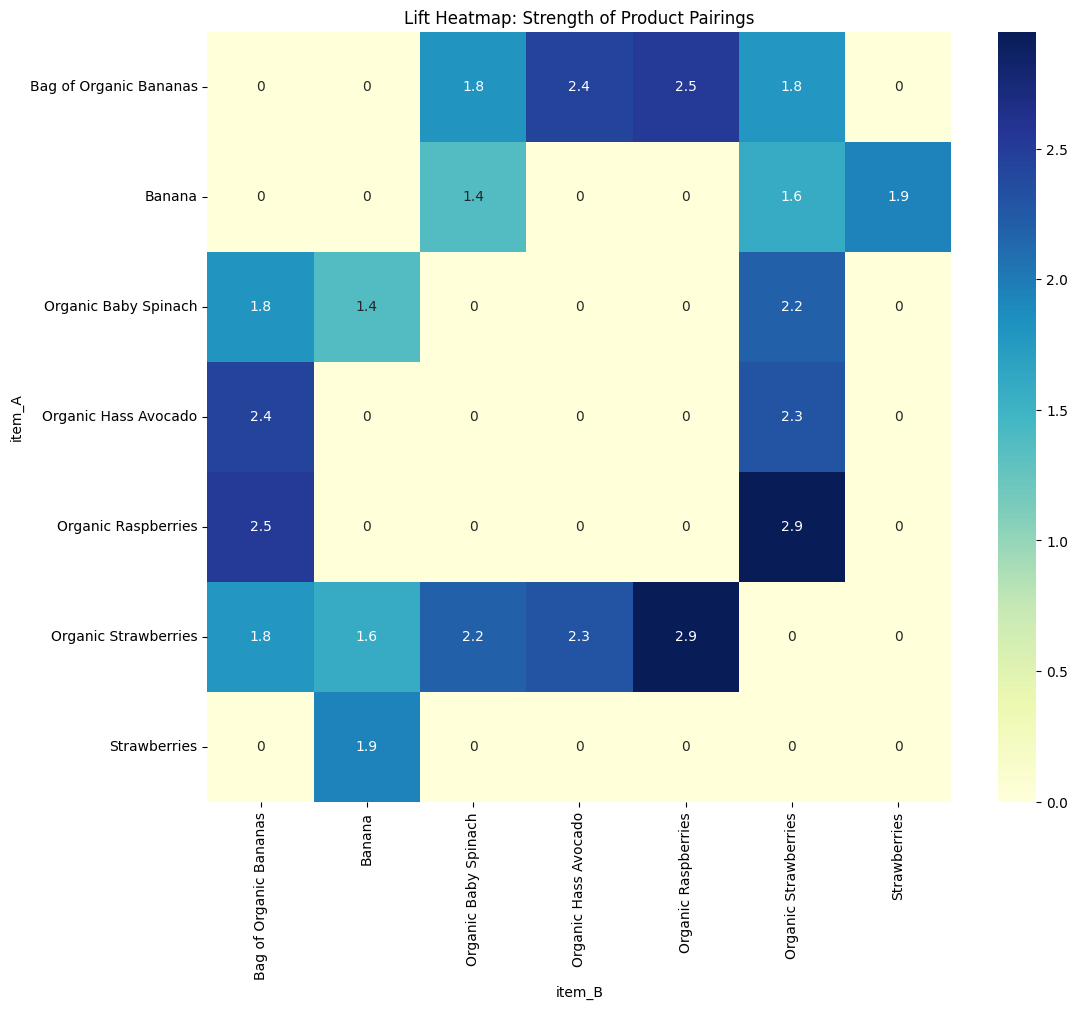

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [36]:
# Final Task B: Relationship Heatmap for Top Items
pivot = rules.head(20).pivot(index='item_A', columns='item_B', values='lift').fillna(0)
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Lift Heatmap: Strength of Product Pairings')
plt.show()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

--- Final Model Evaluation Summary ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

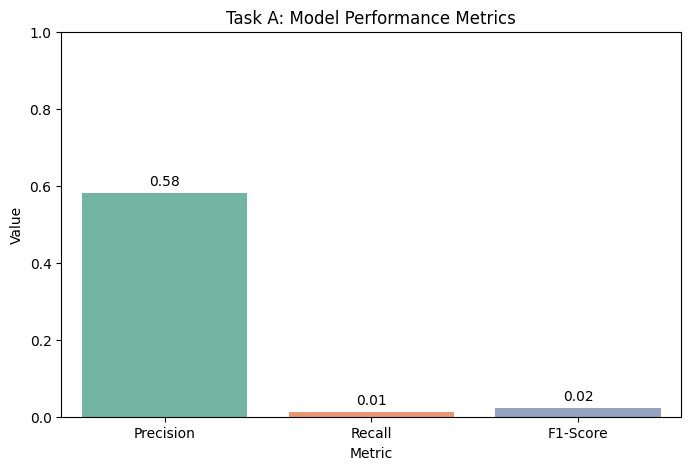

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [37]:
print("--- Final Model Evaluation Summary ---")
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'Value': [precision, recall, f1]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='Set2')
plt.ylim(0, 1)
plt.title('Task A: Model Performance Metrics')
for i, v in enumerate(metrics_df['Value']):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

In [ ]:
rules.to_csv('product_associations.csv', index=False)
final_dataset.head(1000).to_csv('sample_predictions_sample.csv', index=False)
